# PLS using MorganFingerprints and X and fitness as Y
First we collect all the data from all evolutionary experiments.

In [1]:
import glob
from rdkit import Chem, DataStructs
import numpy as np

totFitFiles=0
allCandidates=[]
unqCandidates=[]
unqCandidatesWFitness=[]
fitnesses=[]
molNames=[]
unqUIDs=[]
for fitFile in glob.glob("../run_*/Gen*/*_FIT.sdf"):
    totFitFiles=totFitFiles+1;
    supplier = Chem.SDMolSupplier(fitFile);
    i=0
    for mol in supplier:
        mol.SetProp('Pathname',fitFile)
        i=i+1;
        allCandidates.append(mol)
        if mol.HasProp('UID'):
            if not mol.GetProp('UID') in unqUIDs:
                unqCandidates.append(mol)
                unqUIDs.append(mol.GetProp('UID'))
                if mol.HasProp('FITNESS'):
                    unqCandidatesWFitness.append(mol)
                    fitnesses.append(float(mol.GetProp('FITNESS')))
                    molNames.append(mol.GetProp('_Name'))
    if i > 1:
        print ('ERROR! One SDF file is expected to contain only one molecule!');
        break;
    
print('Total imported FIT files:      ',totFitFiles);
print('Total candidates:              ',len(allCandidates));
print('Unique candidate:              ',len(unqCandidates));
print('Unique candidate with fitness: ',len(unqCandidatesWFitness));

npf = np.array(fitnesses)
Y = (npf - np.min(npf)) / (np.max(npf) - np.min(npf))

Total imported FIT files:       2323
Total candidates:               2323
Unique candidate:               1453
Unique candidate with fitness:  1196


Then we calculate fingerprints that we'll use as descriptors of the cemical entities.

In [2]:
from rdkit.Chem import AllChem
from rdkit.ML.Data import Stats

Xmat = []
bis = []
for mol in unqCandidatesWFitness:
    bi = {}
    bits = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi).ToBitString();
    bitsvec = [int(bit) for bit in bits]
    Xmat.append(bitsvec)
    bis.append(bi);

X = np.array(Xmat)

In [3]:
print('X shape: ',X.shape)
print('Y shape: ',Y.shape)


X shape:  (1196, 2048)
Y shape:  (1196,)


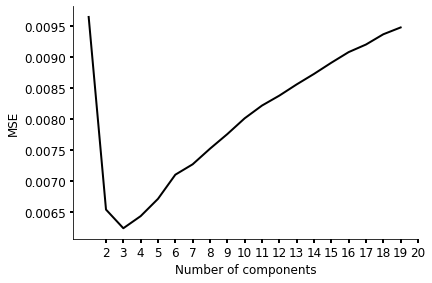

Min at  3  =  0.00624529405144912


In [4]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt

maxNC=20

ncs = []
r2s = []
mses = []
bestPLS = PLSRegression(n_components=1)
for nc in range(1,maxNC):
    #print('----- NC=',nc,' -----')
    pls = PLSRegression(n_components=nc)
    pls.fit(X, Y)
    y_cv = cross_val_predict(pls, X, Y, cv=10)
    score = r2_score(Y, y_cv)
    mse = mean_squared_error(Y, y_cv)
    if nc > 1 and mse < mses[np.argmin(mses)]:
        bestPLS = pls
    #print('score: ',score)
    #print('MSE: ',mse)
    ncs.append(nc)
    r2s.append(score)
    mses.append(mse)
    

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

plt.plot(ncs,mses,'k-',linewidth=2)
plt.ylabel('MSE',fontsize=12)
plt.xlabel('Number of components',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([i+1 for i in range(1,maxNC)])
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)
plt.show()

print('Min at ',np.argmin(mses)+1,' = ',mses[np.argmin(mses)])


Best PLS calibration:
R^2 (calib.):  0.8314010954998201
MSE (calib.):  0.0035525369479915006
Best PLS cross-validation:
R^2 (cross-val):  0.703606253567294
MSE (cross-val):  0.00624529405144912


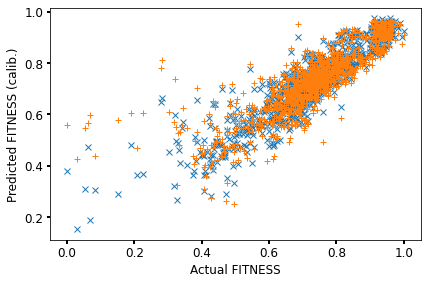

In [5]:
bestPLS.fit(X, Y)

Y_pred = bestPLS.predict(X)

score = r2_score(Y, Y_pred)
mse = mean_squared_error(Y, Y_pred)
print('Best PLS calibration:')
print('R^2 (calib.): ',score)
print('MSE (calib.): ',mse)

Y_cv = cross_val_predict(bestPLS, X, Y, cv=10)

score = r2_score(Y, Y_cv)
mse = mean_squared_error(Y, Y_cv)
print('Best PLS cross-validation:')
print('R^2 (cross-val): ',score)
print('MSE (cross-val): ',mse)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

plt.plot(Y,Y_pred,'x',linewidth=2)
plt.plot(Y,Y_cv,'+',linewidth=2)
plt.ylabel('Predicted FITNESS (calib.)',fontsize=12)
plt.xlabel('Actual FITNESS',fontsize=12)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)
plt.show()


Test PLS calibration:
R^2 (calib.):  0.7878215462821707
MSE (calib.):  0.0044707988977442555
Test PLS cross-validation:
R^2 (cross-val):  0.6893568672244874
MSE (cross-val):  0.006545541977846365


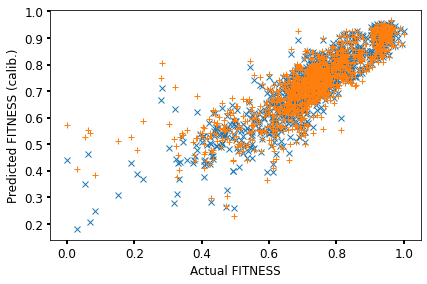

In [6]:
# This is a playground to test different number of components
testPLS = PLSRegression(n_components=2)
testPLS.fit(X, Y)

Y_pred = testPLS.predict(X)

score = r2_score(Y, Y_pred)
mse = mean_squared_error(Y, Y_pred)
print('Test PLS calibration:')
print('R^2 (calib.): ',score)
print('MSE (calib.): ',mse)

Y_cv = cross_val_predict(testPLS, X, Y, cv=10)

score = r2_score(Y, Y_cv)
mse = mean_squared_error(Y, Y_cv)
print('Test PLS cross-validation:')
print('R^2 (cross-val): ',score)
print('MSE (cross-val): ',mse)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

plt.plot(Y,Y_pred,'x',linewidth=2)
plt.plot(Y,Y_cv,'+',linewidth=2)
plt.ylabel('Predicted FITNESS (calib.)',fontsize=12)
plt.xlabel('Actual FITNESS',fontsize=12)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)
plt.show()

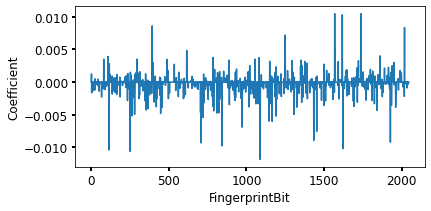

In [7]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

xrange = np.arange(0,2048)
plt.plot(xrange,bestPLS.coef_)
plt.ylabel('Coefficient',fontsize=12)
plt.xlabel('FingerprintBit',fontsize=12)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)
plt.show()